In [1]:
#meta 2/10/2021 Kaggle Cassava Module 1-Model Mini K-fold(for rapid iteration)
#fast.ai 2020 study group Kaggle Competition
#src https://www.kaggle.com/c/cassava-leaf-disease-classification
#prev competition src https://www.kaggle.com/c/cassava-disease
#references https://arxiv.org/pdf/1908.02900.pdf

#input: exported data files from my-cassava-data-v2-mini10pct
#     df_train_kfold.pkl or df_train_mini_kfold.pkl
#output: model artifacts, submission.csv
#pwd: /kaggle/working
#based on version of my-kaggle-cassava-1-model.ipynb -> my-kaggle-cassava-1-model-mini_score0812.ipynb

#prev in my-kaggle-cassava-1-model-mini_score0812.ipynb
#2/7/2021 MODULE 1-MODEL MINI W/ INFERENCE + EXPORT, DELTA BS=64
#      $params: MINI = 1, DS_OVERSAMPLED = 0
#      in MINI mode, train mini ds (not oversampled) (exported from Module 0)
#      dataprep: splitter=ColSplitter(), item_tfms = None, batch_tfms = [ *aug_transforms(flip_vert=True, max_zoom=3.0), Normalize.from_stats(*imagenet_stats)])
#                bs=64
#      model: learn = cnn_learner(dls, resnet18, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)
#      learn.fine_tune(15)
#      preds,_ = learn.get_preds(dl=test_dl), no TTA
#      Score: .812  Time: 10min + submission time, Rank: n/a

#history
#2/10/2021 POC ADD K-FOLD TO MODULE 1-MODEL MINI W/ INFERENCE + EXPORT, DELTA BS=32
#      $params: MINI = 1, DS_OVERSAMPLED = 0
#      in MINI mode, train mini ds (not oversampled) (exported from Module 0)
#      POC train k models and average prediction probabilities.
#      Verified submission works with N_EPOCHS_MINI=2 only (no need to care about the score 0.710)

#here 2/10/2021 ADD K-FOLD TO MODULE 1-MODEL MINI W/ INFERENCE + EXPORT, DELTA BS=32
#      $params: MINI = 1, DS_OVERSAMPLED = 0
#      in MINI mode, train mini ds (not oversampled) (exported from Module 0)
#      dataprep: splitter=ColSplitter(), item_tfms = None, batch_tfms = [ *aug_transforms(flip_vert=True, max_zoom=3.0), Normalize.from_stats(*imagenet_stats)])
#                bs=32
#      model: learn = cnn_learner(dls, resnet18, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)
#      learn.fine_tune(15)
#      preds,_ = learn.get_preds(dl=test_dl), no TTA
#      Score: .?  Time: ?min + submission time, Rank: n/a


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import os
import time #to track performance time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#modeling
from fastai.vision.all import *


# Input data files are available in the read-only "../input/" directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
#--constants and variables
SEED = 24 
MINI = 1 #$params
DS_OVERSAMPLED = 0 #$params
BATCH_SIZE = 32 #$params
N_EPOCHS_FULL = 15 #$params
N_EPOCHS_MINI = 15 #$params
N_EPOCHS_FREEZE = 3 #$params

#set paths
path = Path('../input/cassava-leaf-disease-classification')
path_data = Path('../input/my-cassava-data-v2-mini10pct')
path_model = Path("/kaggle/working/")

#--functions
def get_x(row): return path/'train_images'/row['image_id']
def get_y(row): return row['label']


# Cassava Disease Classification
##### Objective: Classify pictures of cassava leaves into 1 of 4 disease categories or healthy.

Mini mode for rapid iteration


## 0. Load Data


### 0.1 Images  
21397 train images and 1 test image

In [4]:
#(path/'train_images').ls(), (path/'test_images').ls()

In [5]:
#load train/test images
#train_img = get_image_files(path/'train_images')
#test_img = get_image_files(path/'test_images')

#print("Number of files: ", (len(train_img), len(test_img)))

### 0.3 Train Dataset
Export from module 0-Data, 5 k-folds

In [6]:
#$param
if MINI:
    df_train = torch.load(path_data/'df_train_mini_kfold.pkl')
else:
    df_train = torch.load(path_data/'df_train_kfold.pkl')
        
print('train data\n', df_train.shape)
display(df_train.head())

train data
 (2140, 4)


,index,image_id,label,k_fold
0,19,1003987001.jpg,3,2
1,23,1004672608.jpg,3,0
2,24,100472565.jpg,2,3
3,27,1005138819.jpg,3,2
4,42,1008244905.jpg,1,4


In [7]:
#get k-folds
K_FOLDS = df_train['k_fold'].nunique()
K_FOLDS

5

In [8]:
#make into k datasets: 5 train sets and 5 validation sets
df_train_kfolds = []

df_train_grp = df_train.groupby('k_fold')
for idx, grp in df_train_grp:
    print(grp.shape)
    print(grp.head())
    
    #get idx for valid ds
    valid_idx = grp.index
    #print(idx_valid)
    
    #update df_train_kfold with valid index 
    df_train_kfold = df_train.copy()
    df_train_kfold['is_valid'] = 0
    df_train_kfold.loc[df_train_kfold.index.isin(valid_idx), 'is_valid'] = 1
    
    #vis with valid index 
    #print(df_train_kfold['is_valid'].value_counts())
    
    df_train_kfolds.append(df_train_kfold)

#confirm k-folds
print(len(df_train_kfolds))

(428, 4)
    index        image_id  label k_fold
1      23  1004672608.jpg      3      0
8      79  1012902365.jpg      4      0
16    130  1022932733.jpg      4      0
35    278  1048686894.jpg      2      0
40    335  1059782259.jpg      3      0
(428, 4)
    index        image_id  label k_fold
12     90  1015034348.jpg      3      1
19    160  1028105805.jpg      3      1
21    169  1029779424.jpg      3      1
29    221  1041184552.jpg      3      1
30    226  1041922165.jpg      2      1
(428, 4)
    index        image_id  label k_fold
0      19  1003987001.jpg      3      2
3      27  1005138819.jpg      3      2
15    125  1022283943.jpg      3      2
23    175  1032460539.jpg      2      2
26    190  1035475040.jpg      3      2
(428, 4)
    index        image_id  label k_fold
2      24   100472565.jpg      2      3
5      49  1009268848.jpg      3      3
9      84  1014359226.jpg      2      3
10     85  1014365825.jpg      3      3
11     89  1014888611.jpg      3      3
(428

In [9]:
for df_kfold in df_train_kfolds:
    print(df_kfold.head())
    print(df_kfold['is_valid'].value_counts().sort_index())

   index        image_id  label k_fold  is_valid
0     19  1003987001.jpg      3      2         0
1     23  1004672608.jpg      3      0         1
2     24   100472565.jpg      2      3         0
3     27  1005138819.jpg      3      2         0
4     42  1008244905.jpg      1      4         0
0    1712
1     428
Name: is_valid, dtype: int64
   index        image_id  label k_fold  is_valid
0     19  1003987001.jpg      3      2         0
1     23  1004672608.jpg      3      0         0
2     24   100472565.jpg      2      3         0
3     27  1005138819.jpg      3      2         0
4     42  1008244905.jpg      1      4         0
0    1712
1     428
Name: is_valid, dtype: int64
   index        image_id  label k_fold  is_valid
0     19  1003987001.jpg      3      2         1
1     23  1004672608.jpg      3      0         0
2     24   100472565.jpg      2      3         0
3     27  1005138819.jpg      3      2         1
4     42  1008244905.jpg      1      4         0
0    1712
1     428


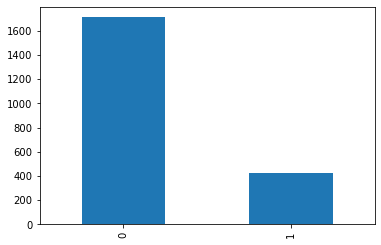

In [10]:
df_train_kfolds[0]['is_valid'].value_counts().sort_index().plot(kind='bar');


### 1.1 From Data to Dataloaders
with DataBlock

In [11]:
##dataloaders
#dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
#                 get_x = get_x,
#                 get_y = get_y,
#                 splitter=ColSplitter(), 
#                 item_tfms = None, 
#                 batch_tfms = [ *aug_transforms(flip_vert=True, max_zoom=3.0), Normalize.from_stats(*imagenet_stats)])
#                      

#dls = dblock.dataloaders(df_train, bs=BATCH_SIZE)

#len(dls.train_ds), len(dls.valid_ds)

In [12]:
#wrap dataloaders code into a function
def get_data(fold):
    this_dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_x = get_x,
                 get_y = get_y,
                 splitter=ColSplitter(), 
                 item_tfms = None, 
                 batch_tfms = [ *aug_transforms(flip_vert=True, max_zoom=3.0), Normalize.from_stats(*imagenet_stats)])
    this_dls = this_dblock.dataloaders(df_train_kfolds[fold], bs=BATCH_SIZE)
    
    return this_dls #class fastai.data.core.DataLoaders

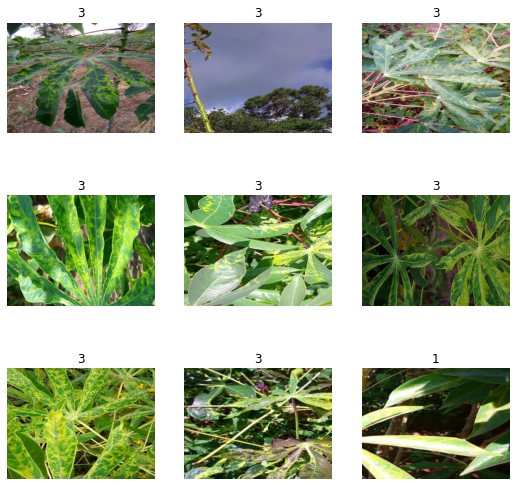

In [13]:
#preview
dls = get_data(0)
dls.train.show_batch()

## 2. Model
Learn a model to classify a given image into these 4 disease categories or a 5th category indicating a healthy leaf, using the images in the training data

### 2.0 Pretrained model offline

In [14]:
#src Daniel
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
        os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/resnet185c106cdepth/resnet18-5c106cde.pth' '/root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth'

### 2.1 Train K-Folds
Mini training n_epochs.

In [15]:
set_seed(SEED)

#torch.cuda.empty_cache()
def free_gpu_cache():
    torch.cuda.empty_cache()

In [16]:
##track time
#t0 = time.time()

##Ch7 pg251 LabelSmoothingCrossEntropy()
#learn = cnn_learner(dls, resnet18, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)
#if MINI:
#    learn.fine_tune(N_EPOCHS_MINI) #$param
#else:
#    learn.fine_tune(N_EPOCHS_FULL) #$param

#print ("Training time (in min)", (time.time() - t0)/60)

fold 0


epoch,train_loss,valid_loss,accuracy,time
0,2.178101,1.629383,0.535047,00:34


epoch,train_loss,valid_loss,accuracy,time
0,1.624989,1.212012,0.640187,00:35
1,1.521522,1.122424,0.670561,00:34
2,1.424068,1.086127,0.691589,00:35
3,1.295141,1.241603,0.619159,00:35
4,1.197643,1.040828,0.726636,00:35
5,1.109006,0.995375,0.721963,00:35
6,1.036279,0.919513,0.775701,00:35
7,0.963187,0.919797,0.745327,00:35
8,0.924051,0.857853,0.771028,00:35
9,0.915827,0.821720,0.803738,00:36


Training time (in min) 9.434368813037873
fold 1


epoch,train_loss,valid_loss,accuracy,time
0,2.214199,1.663613,0.471963,00:30


epoch,train_loss,valid_loss,accuracy,time
0,1.658948,1.379755,0.558411,00:35
1,1.542858,1.323777,0.581776,00:35
2,1.442000,1.132385,0.679907,00:35
3,1.320177,1.335631,0.591121,00:35
4,1.189892,1.093988,0.705607,00:35
5,1.118912,0.955698,0.778037,00:35
6,1.037449,0.948435,0.773364,00:35
7,0.978295,0.904644,0.778037,00:35
8,0.953956,0.839536,0.787383,00:35
9,0.907562,0.851498,0.799065,00:35


Training time (in min) 9.34321893453598
fold 2


epoch,train_loss,valid_loss,accuracy,time
0,2.173530,1.566815,0.523364,00:30


epoch,train_loss,valid_loss,accuracy,time
0,1.679967,1.304458,0.591121,00:35
1,1.524873,1.145739,0.689252,00:35
2,1.355224,1.201515,0.656542,00:35
3,1.278812,1.004765,0.721963,00:35
4,1.173583,0.994644,0.735981,00:35
5,1.100059,0.980608,0.740654,00:35
6,1.017789,0.948629,0.754673,00:35
7,0.984226,0.918541,0.782710,00:35
8,0.924037,0.884876,0.782710,00:35
9,0.889455,0.860791,0.785047,00:35


Training time (in min) 9.350599567095438
fold 3


epoch,train_loss,valid_loss,accuracy,time
0,2.146332,1.317723,0.647196,00:30


epoch,train_loss,valid_loss,accuracy,time
0,1.576428,1.246167,0.621495,00:35
1,1.458930,1.068149,0.698598,00:34
2,1.380592,1.139215,0.654206,00:34
3,1.257185,0.965993,0.750000,00:35
4,1.180998,0.892257,0.801402,00:35
5,1.098790,0.851133,0.822430,00:35
6,1.007886,0.910573,0.768692,00:35
7,0.978908,0.782328,0.829439,00:34
8,0.930573,0.797419,0.829439,00:35
9,0.892666,0.760304,0.843458,00:36


Training time (in min) 9.343114562829335
fold 4


epoch,train_loss,valid_loss,accuracy,time
0,2.076731,1.365425,0.612150,00:30


epoch,train_loss,valid_loss,accuracy,time
0,1.687798,1.127572,0.661215,00:35
1,1.500998,1.119989,0.658879,00:35
2,1.413174,1.047245,0.726636,00:35
3,1.279431,0.972981,0.771028,00:35
4,1.185882,0.950084,0.775701,00:35
5,1.113145,0.932507,0.794393,00:35
6,1.007378,0.790044,0.831776,00:35
7,0.968369,0.828457,0.799065,00:35
8,0.932909,0.798220,0.824766,00:35
9,0.895425,0.823558,0.810748,00:36


Training time (in min) 9.342517753442129
Total training time (in min) 9.345097796122234


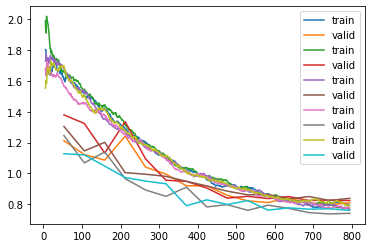

In [17]:
#train k-folds models
for i in range(K_FOLDS):
    
    print("fold", i)
    dls = get_data(i) # Data
    #len(dls.train),len(dls.valid)
    #dls.show(5)
    
    name = 'model_' + str(i) 
    
    #track time
    t0 = time.time()
    
    free_gpu_cache() 

    #setup learner
    learn = cnn_learner(dls, resnet18, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)
    if MINI:
        learn.fine_tune(N_EPOCHS_MINI) #$param
    else:
        learn.fine_tune(N_EPOCHS_FULL) #$param

    print ("Training time (in min)", (time.time() - t0)/60)
    
    #save the state of your model
    #if MINI:
    #    learn.save('my-mini-15epochs64bs')
    #else:
    #    learn.save('my-full-15epochs64bs') #$param

    #export model
    learn.export('/kaggle/working/'+name+'.pkl') 
    
    #if no error CUDA out of memory
    learn.recorder.plot_loss()
    
print ("Total training time (in min)", (time.time() - t0)/60) 

In [18]:
##save the state of your model
#if MINI:
#    learn.save('my-mini-15epochs64bs')
#else:
#    learn.save('my-full-15epochs64bs') #$param
    
##export model
#learn.export()

In [19]:
#last learner
#learn.recorder.plot_loss()

### 2.2 Evaluate

In [20]:
#use exports for inference
#learn = load_learner($param path'/export.pkl')

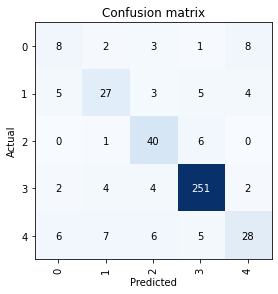

In [21]:
#last learner
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [22]:
#last learner
interp.most_confused(min_val=10)

[]

## 3. Predict with K-models

- Predict one image

In [23]:
#view test images - only one
test_img = get_image_files(path/'test_images')
Image.open(test_img[0])

#predict one image with one model, returns a tuple, get 0th item
y_hat = learn.predict(test_img[0])
y_hat[0]

'4'

In [24]:
#predict one image with k models, returns a tuple, get 0th item

y_hats = []
for i in range(K_FOLDS):
    learner = load_learner(path_model/f'model_{i}.pkl')
    y_hat = learn.predict(test_img[0])
    y_hats += [y_hat]

y_hats

[('4', tensor(4), tensor([0.0296, 0.0391, 0.1166, 0.2507, 0.5641])),
 ('4', tensor(4), tensor([0.0296, 0.0391, 0.1166, 0.2507, 0.5641])),
 ('4', tensor(4), tensor([0.0296, 0.0391, 0.1166, 0.2507, 0.5641])),
 ('4', tensor(4), tensor([0.0296, 0.0391, 0.1166, 0.2507, 0.5641])),
 ('4', tensor(4), tensor([0.0296, 0.0391, 0.1166, 0.2507, 0.5641]))]

- Predict test ds images

In [25]:
#template
sample_submission = pd.read_csv(path/'sample_submission.csv')
submission = sample_submission.copy()

#create test images id
test_img_id = [os.path.join(path/'test_images', x) for x in submission['image_id'].values]

#images in test files
test_img_id

['../input/cassava-leaf-disease-classification/test_images/2216849948.jpg']

In [26]:
#predict test images with one model
test_dl = dls.test_dl(test_img_id)
len(test_dl)

#predict, no TTA
preds,_ = learn.get_preds(dl=test_dl)
#preds

#submission
submission['label'] = preds.argmax(dim=-1).numpy()
submission.head()

,image_id,label
0,2216849948.jpg,4


In [27]:
#Predictions and DataStructs
#preds, preds.argmax(dim=-1), preds.argmax(dim=-1).numpy()

In [28]:
#predict test images with k models
fold_preds = []
for i in range(K_FOLDS):
    learner = load_learner(path_model/f'model_{i}.pkl')
    test_dl = dls.test_dl(test_img_id)
    #predict, no TTA
    preds,_ = learn.get_preds(dl=test_dl)
    #preds
    fold_preds += [preds]
preds = torch.stack(fold_preds)

#submission
submission['label'] = preds.sum(axis=0).argmax(dim=-1).numpy() #preds.argmax(dim=-1).numpy()
submission.head()

,image_id,label
0,2216849948.jpg,4


#### Predictions and DataStructs
Ideally, select mode of all k-fold predictions.  If need a tie-break, mode doesn't work.  
Better: highest mean probabilities.

In [29]:
#preds.sum(axis=0), preds.sum(axis=0).argmax(),preds.sum(axis=0).argmax(dim=-1).numpy()

## 4. Submit


In [30]:
submission.to_csv('submission.csv', index=False)


# Xtra

In [31]:
# try: solve CUDA out of memory error
#src https://www.kaggle.com/getting-started/140636
#!pip install GPUtil

#import torch
#from GPUtil import showUtilization as gpu_usage
#from numba import cuda

In [32]:
#def free_gpu_cache():
#    print("Initial GPU Usage")
#    gpu_usage()                             

#    torch.cuda.empty_cache()

    #cuda.select_device(0)
    #cuda.close()
    #cuda.select_device(0)

#    print("GPU Usage after emptying the cache")
#    gpu_usage()


In [33]:
'''#scipy.stats and mode example
a = np.array([[1, 3, 4, 2, 2, 7],
              [5, 2, 2, 1, 4, 1],
              [3, 3, 2, 2, 1, 1]])

m = stats.mode(a)
print(m)
m = stats.mode(a, axis=1)
print(m)
m = stats.mode(a, axis=None)
print(m)
'''

'#scipy.stats and mode example\na = np.array([[1, 3, 4, 2, 2, 7],\n              [5, 2, 2, 1, 4, 1],\n              [3, 3, 2, 2, 1, 1]])\n\nm = stats.mode(a)\nprint(m)\nm = stats.mode(a, axis=1)\nprint(m)\nm = stats.mode(a, axis=None)\nprint(m)\n'

In [34]:
'''#originally, select Mode of all k-fold predictions
print(preds) #class 'torch.Tensor'
print(preds.argmax(dim=-1).numpy()) #class 'numpy.ndarray'
print(stats.mode(preds.argmax(dim=-1).numpy())[0]) #class 'numpy.ndarray'

#view all three
preds, preds.argmax(dim=-1).numpy(), stats.mode(preds.argmax(dim=-1).numpy())[0]
'''

"#originally, select Mode of all k-fold predictions\nprint(preds) #class 'torch.Tensor'\nprint(preds.argmax(dim=-1).numpy()) #class 'numpy.ndarray'\nprint(stats.mode(preds.argmax(dim=-1).numpy())[0]) #class 'numpy.ndarray'\n\n#view all three\npreds, preds.argmax(dim=-1).numpy(), stats.mode(preds.argmax(dim=-1).numpy())[0]\n"